In [1]:
%pylab inline


import numpy as np
import torch
import os
import sys
import pickle
#Importing the package
path = '/pbs/home/c/campagne/my_sps/MacroCanoniqueStat/'
sys.path.append(os.path.abspath(path+'WCRG'))
sys.path.append(os.path.abspath(path+'WCRG/WCRG'))
sys.path.append(os.path.abspath(path+'WCRG/Wavelet_Packets'))
sys.path.append(os.path.abspath(path+'WCRG/WCRG/Models'))
#Wavelets
from Wavelet_Packets import *
#Ansatz
from WCRG import *

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
#data
dirIn='./maps05_v1/'
data = np.load(dirIn+'maps.npy')

data = data**(-0.5) # to get normal distribution

Data = torch.tensor(data).to(device).to(torch.float32)
print(Data.mean(),Data.std())
#Normalising Data
Data= (Data - Data.mean())/Data.std()
print(Data.shape)
#Computing the number of scales
J=int(np.log2(Data.shape[-1])) #Images of size 2**J
print('J = '+str(J))

tensor(3.1253, device='cuda:0') tensor(0.3610, device='cuda:0')
torch.Size([5000, 128, 128])
J = 7


In [4]:
#Wavelet
m=4
W=Db_wavelets(m,device=device,mode='Periodic') #Debauchies 4

In [5]:
# I/O of model/synthesis
KEY="map_128"
dir_synth = './Synths/'
dir_mod = './Models/'

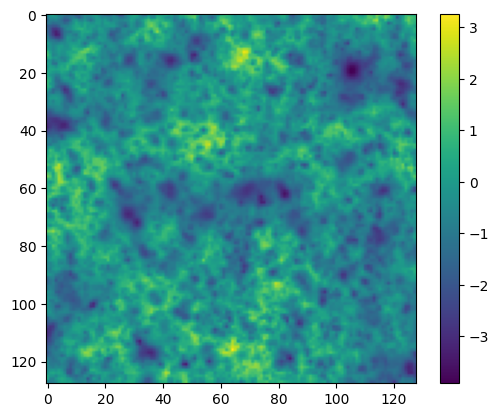

tensor(-0.4174, device='cuda:0')


In [6]:
imshow(Data[0].cpu());colorbar();
show()
print(Data[0].mean())

In [7]:
def my_optim(ansatz_union,dataloader,num_epochs,lr,momentum=0,weight_decay=0):
    """Ansatz optimisation with SGD
    
    Parameters:
    ansatz_union (Condi_union) : ansatz to optimise
    dataloader (torch Dataloader):  with x_{j-1} maps for conditional models
    num_epochs (int) :number of steps
    lr (float) : learning rate
    momentum : momentum in SGD
    weight_decay : l2 renormalisation in SGD
    
    """

    optimizer = torch.optim.SGD([ansatz_union.theta_no_rescale], lr=lr, momentum=momentum, weight_decay=weight_decay)
    for _ in range(num_epochs):
        for x in dataloader:
            l=Loss_score(x,ansatz_union)
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        print( '[{}/{}] loss: {:.8}'.format(_, num_epochs, l.cpu().detach().numpy() ) )

# We train the ansatz $E(x_J)$

In [153]:
#Loading Data x_J
L=1
depth = J-int(np.log2(L))
phi_s = load_data(W,Data,depth,J,show_hist=False)

In [154]:
phi_s.shape

torch.Size([5000, 1, 1])

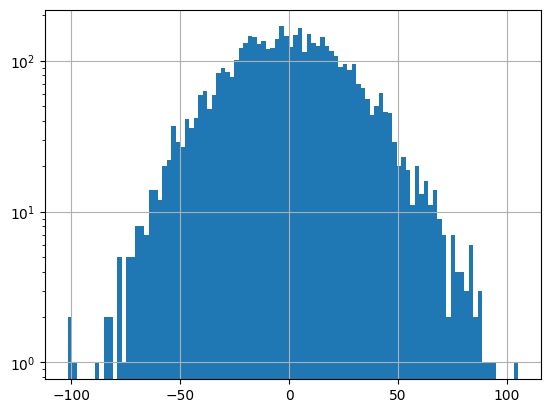

In [156]:
plt.hist(phi_s.cpu().reshape((-1)),bins=100);
plt.yscale('log')
plt.grid()
plt.show()

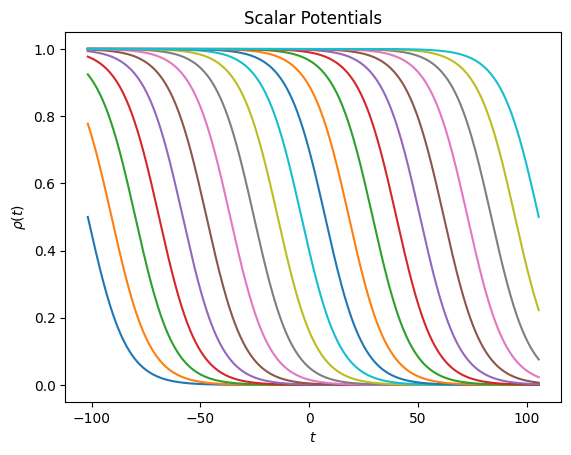

In [160]:
#Scalar Potentials Positioning
num_potentials = 20
# For linspaced potentials
window_min,window_max = phi_s.min(),phi_s.max() #The window to consider for scalar potentials
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =0.8,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials, quantile_min=0.001,quantile_max=0.999,
#                                 extent=1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = ()
#Ansatz
ansatz = ANSATZ_NoCondi(L,centers,sigma,shifts,shifts_sym = False)

In [161]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s, batch_size=1000)
#Normalise Hessian in order to improve conditionning
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
#Optimisation
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/30] loss: -0.00068861491
[1/30] loss: -0.0011023695
[2/30] loss: -0.0012977754
[3/30] loss: -0.0013093509
[4/30] loss: -0.001323655
[5/30] loss: -0.0011354698
[6/30] loss: -0.0012475215
[7/30] loss: -0.0012100617
[8/30] loss: -0.0013061668
[9/30] loss: -0.0012101496
[10/30] loss: -0.0013942955
[11/30] loss: -0.0013718824
[12/30] loss: -0.0012475519
[13/30] loss: -0.0012830569
[14/30] loss: -0.0014538374
[15/30] loss: -0.0013643368
[16/30] loss: -0.001377927
[17/30] loss: -0.0012125805
[18/30] loss: -0.0013890262
[19/30] loss: -0.0012665893
[20/30] loss: -0.0012856909
[21/30] loss: -0.0013019277
[22/30] loss: -0.001229887
[23/30] loss: -0.0014880201
[24/30] loss: -0.0012959143
[25/30] loss: -0.0012369629
[26/30] loss: -0.0012618507
[27/30] loss: -0.0014285059
[28/30] loss: -0.0013085708
[29/30] loss: -0.0014158667
[0/10] loss: -0.0012721037
[1/10] loss: -0.0012396587
[2/10] loss: -0.0012696342
[3/10] loss: -0.001370062
[4/10] loss: -0.0013429716
[5/10] loss: -0.0013833252
[6/10] loss

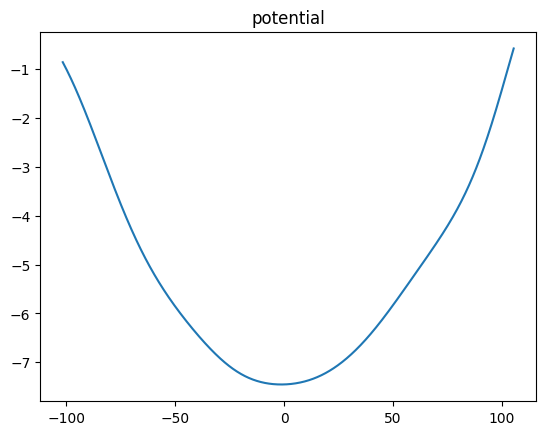

In [162]:
#Visualize Potential
Show_Sigmoid(ansatz,add_Trace=True,Free=False,index_scalar=0,index_quad=1)

In [163]:
KEY="map_128"
dir_synth = './Synths/'
dir_mod = './Models/'


In [164]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 2

In [165]:
#Loading Data x_j
L=2
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 6


In [166]:
phi_s.shape

torch.Size([5000, 2, 2])

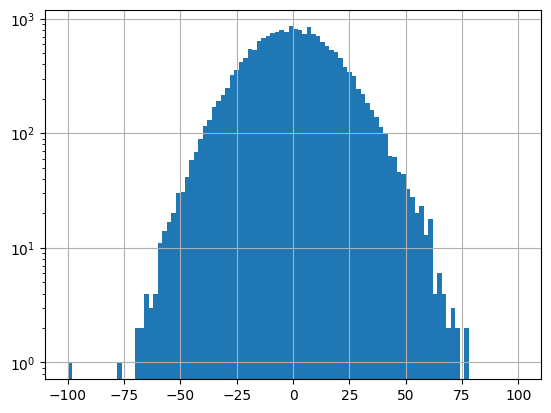

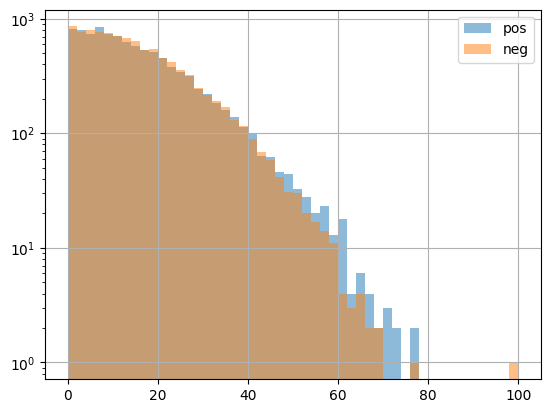

In [176]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-100,100));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,100),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,100),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

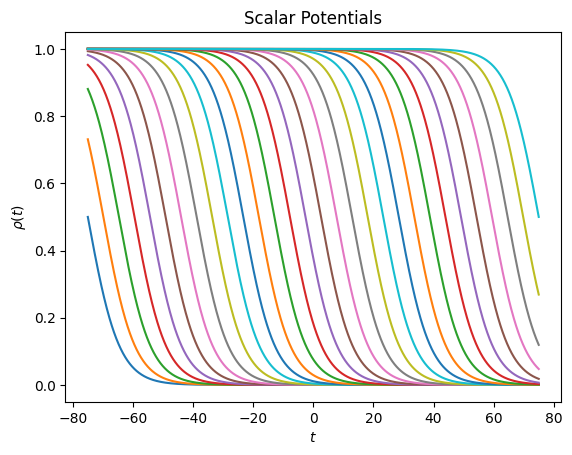

In [177]:
#Scalar Potentials Positioning
num_potentials = 30
window_min,window_max = (-75,75)# phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials, quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = ()
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [178]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s, batch_size=1000)
#Normalise Hessian in order to improve conditionning
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=20,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)


[0/20] loss: -0.008299836
[1/20] loss: -0.01118918
[2/20] loss: -0.012284505
[3/20] loss: -0.011521441
[4/20] loss: -0.012545147
[5/20] loss: -0.012872479
[6/20] loss: -0.013008006
[7/20] loss: -0.012506073
[8/20] loss: -0.013035559
[9/20] loss: -0.013974709
[10/20] loss: -0.012130191
[11/20] loss: -0.012733608
[12/20] loss: -0.013360179
[13/20] loss: -0.012314122
[14/20] loss: -0.01366078
[15/20] loss: -0.012061005
[16/20] loss: -0.012864634
[17/20] loss: -0.013245014
[18/20] loss: -0.01286945
[19/20] loss: -0.012816807
[0/10] loss: -0.01245782
[1/10] loss: -0.012882745
[2/10] loss: -0.013344952
[3/10] loss: -0.012659752
[4/10] loss: -0.012631963
[5/10] loss: -0.01212333
[6/10] loss: -0.012786604
[7/10] loss: -0.013267971
[8/10] loss: -0.012174983
[9/10] loss: -0.011762162


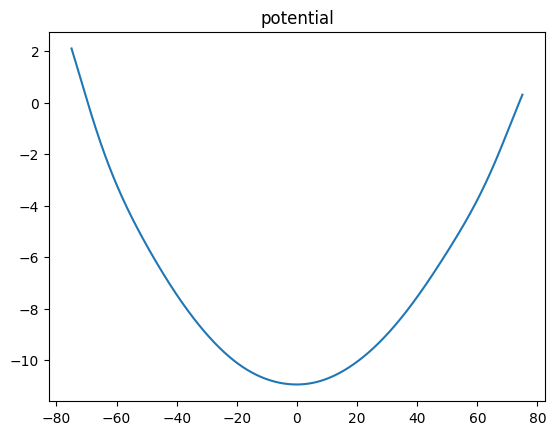

In [181]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [182]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 4

In [183]:
L=4
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 5


In [184]:
phi_s.shape

torch.Size([5000, 4, 4])

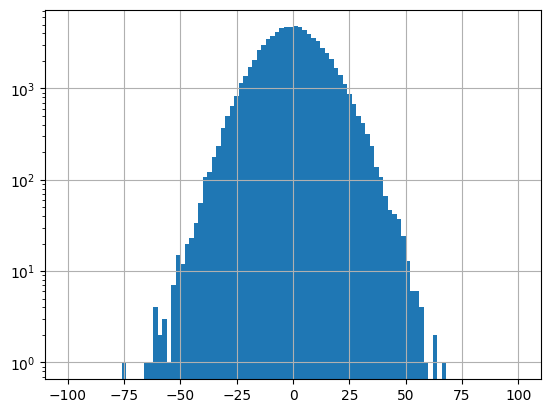

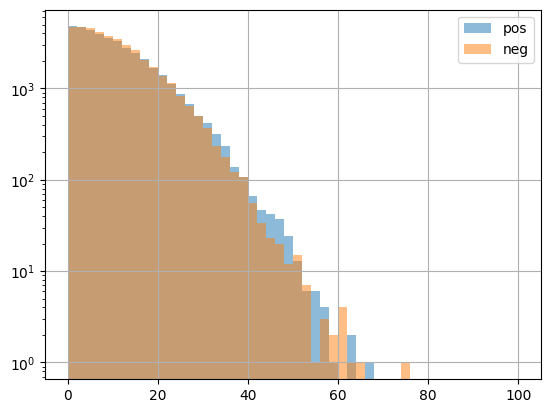

In [185]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-100,100));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,100),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,100),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

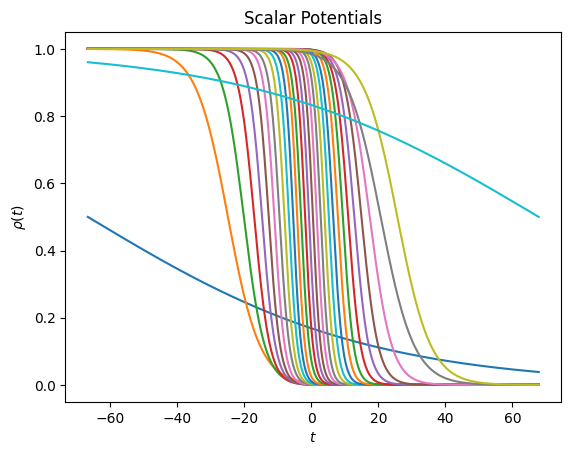

In [203]:
#Scalar Potentials Positioning
num_potentials = 30
#window_min,window_max = (-65,65)# phi_s.min(),phi_s.max()#phi_s.min(),phi_s.max()
#centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.00001,quantile_max=1.0,
                                 extent =1,device=device)
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = ((1,0),(0,1),(1,1))
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts,shifts_sym=True)

In [204]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=100)
#Normalise Hessian in order to improve conditionning
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-3,momentum=0,weight_decay=0)


[0/30] loss: -0.063260451
[1/30] loss: -0.084341079
[2/30] loss: -0.094619177
[3/30] loss: -0.092462249
[4/30] loss: -0.099045008
[5/30] loss: -0.10127671
[6/30] loss: -0.1122573
[7/30] loss: -0.10698358
[8/30] loss: -0.10264023
[9/30] loss: -0.10876259
[10/30] loss: -0.10580695
[11/30] loss: -0.10566243
[12/30] loss: -0.10988485
[13/30] loss: -0.10148633
[14/30] loss: -0.11712533
[15/30] loss: -0.10054547
[16/30] loss: -0.11390818
[17/30] loss: -0.11175805
[18/30] loss: -0.099656373
[19/30] loss: -0.11074721
[20/30] loss: -0.1080772
[21/30] loss: -0.093498968
[22/30] loss: -0.10588934
[23/30] loss: -0.10546315
[24/30] loss: -0.1039919
[25/30] loss: -0.11540023
[26/30] loss: -0.094591655
[27/30] loss: -0.083619334
[28/30] loss: -0.0962767
[29/30] loss: -0.11395444
[0/30] loss: -0.092684649
[1/30] loss: -0.10433724
[2/30] loss: -0.10609891
[3/30] loss: -0.12830153
[4/30] loss: -0.11761258
[5/30] loss: -0.11640098
[6/30] loss: -0.11170972
[7/30] loss: -0.10296326
[8/30] loss: -0.1204828


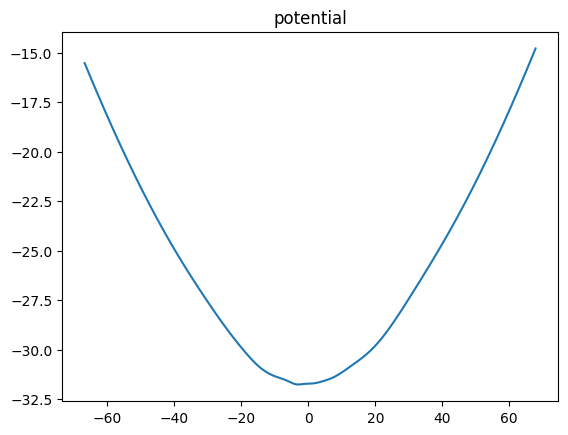

In [205]:
#Visualize Potential
Show_Sigmoid(ansatz)


In [206]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L= 8

In [242]:
L=8
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 4


In [243]:
phi_s.shape

torch.Size([5000, 8, 8])

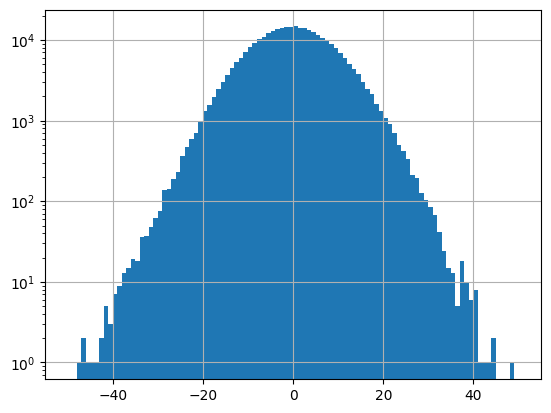

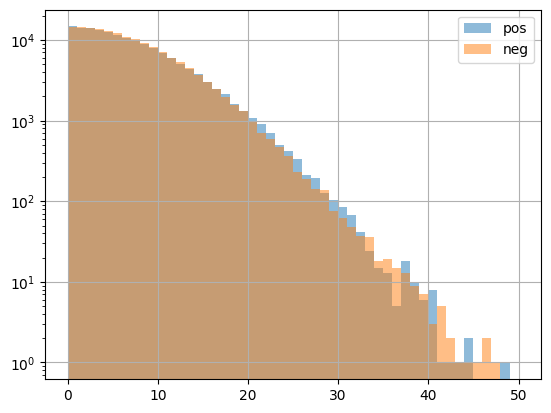

In [244]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-50,50));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,50),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,50),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

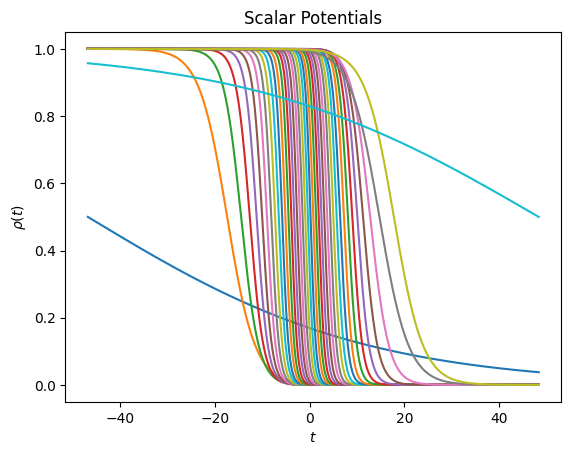

In [245]:
#Scalar Potentials Positioning
num_potentials = 40
#window_min,window_max = (-50,50)# phi_s.min(),phi_s.max()
#centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.00001,quantile_max=1.0,
                                 extent =1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(2,2)  # shifts_quad(2,2) #JEC 14/June+23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [246]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::5], batch_size=100)
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=30,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/30] loss: -0.9873482
[1/30] loss: -1.1292112
[2/30] loss: -1.1982147
[3/30] loss: -1.1385993
[4/30] loss: -1.1332874
[5/30] loss: -1.1351873
[6/30] loss: -1.2088764
[7/30] loss: -1.2830352
[8/30] loss: -1.1788958
[9/30] loss: -1.1774006
[10/30] loss: -1.2268157
[11/30] loss: -1.1949036
[12/30] loss: -1.2219892
[13/30] loss: -1.166573
[14/30] loss: -1.1103853
[15/30] loss: -1.3028415
[16/30] loss: -1.1934251
[17/30] loss: -1.2137699
[18/30] loss: -1.1584562
[19/30] loss: -1.2607526
[20/30] loss: -1.1545341
[21/30] loss: -1.1104201
[22/30] loss: -1.1256163
[23/30] loss: -1.1805446
[24/30] loss: -1.1021006
[25/30] loss: -1.2313043
[26/30] loss: -1.1558287
[27/30] loss: -1.2017255
[28/30] loss: -1.2178392
[29/30] loss: -1.2581754
[0/10] loss: -1.2324096
[1/10] loss: -1.116904
[2/10] loss: -1.2460209
[3/10] loss: -1.143348
[4/10] loss: -1.1409978
[5/10] loss: -1.24262
[6/10] loss: -1.2189319
[7/10] loss: -1.2002006
[8/10] loss: -1.2582961
[9/10] loss: -1.100096


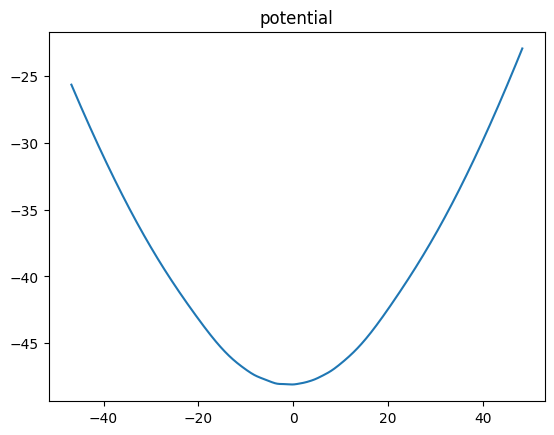

In [247]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [248]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 16

In [120]:
L=16
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 3


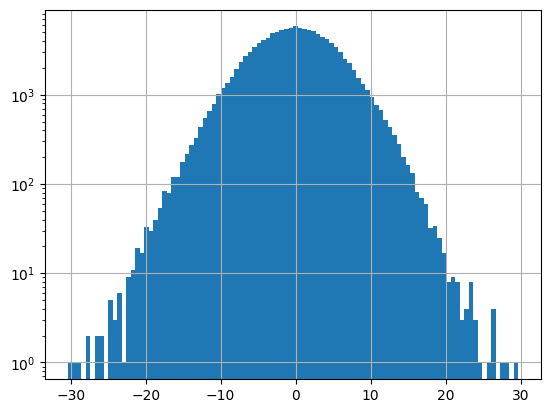

In [121]:
plt.hist(phi_s[::10].cpu().reshape((-1)),bins=100);
plt.yscale('log')
plt.grid()
plt.show()

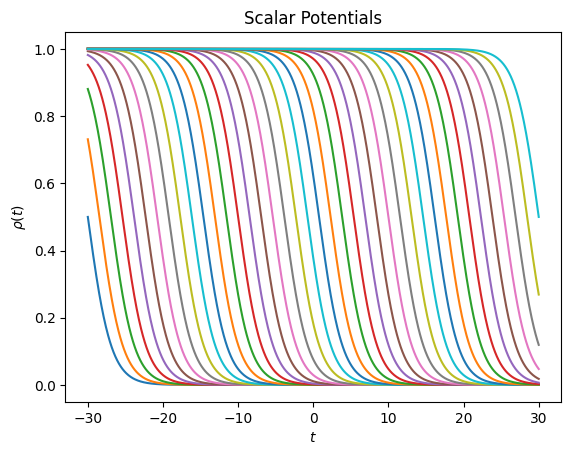

In [122]:
#Scalar Potentials Positioning
num_potentials = 40
window_min,window_max = (-30,30) #phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(4,4)  #shifts_quad(4,4)  # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [123]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=100)
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=False)
my_optim(ansatz,dataloader,num_epochs=50,lr=5e-3,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/50] loss: -4.7481403
[1/50] loss: -8.3205338
[2/50] loss: -10.573259
[3/50] loss: -11.886114
[4/50] loss: -12.732683
[5/50] loss: -13.395671
[6/50] loss: -13.544949
[7/50] loss: -14.230999
[8/50] loss: -14.188199
[9/50] loss: -14.433505
[10/50] loss: -14.327427
[11/50] loss: -14.822267
[12/50] loss: -14.546162
[13/50] loss: -14.916777
[14/50] loss: -14.96298
[15/50] loss: -15.113233
[16/50] loss: -15.293115
[17/50] loss: -14.872817
[18/50] loss: -14.705485
[19/50] loss: -14.794709
[20/50] loss: -14.795058
[21/50] loss: -14.934599
[22/50] loss: -14.971399
[23/50] loss: -14.625899
[24/50] loss: -15.038523
[25/50] loss: -15.140473
[26/50] loss: -15.243382
[27/50] loss: -15.142952
[28/50] loss: -14.89424
[29/50] loss: -14.981345
[30/50] loss: -15.098544
[31/50] loss: -15.715027
[32/50] loss: -15.144782
[33/50] loss: -15.38364
[34/50] loss: -15.455534
[35/50] loss: -14.981057
[36/50] loss: -15.284383
[37/50] loss: -15.234181
[38/50] loss: -15.11192
[39/50] loss: -14.921495
[40/50] loss: 

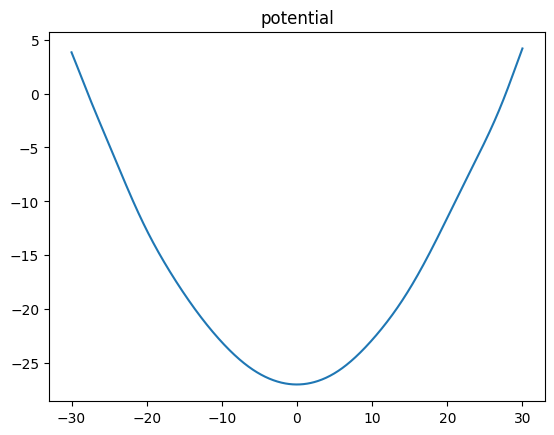

In [124]:
#Visualize Potential
Show_Sigmoid(ansatz)


In [125]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 32

In [258]:
L=32
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 2


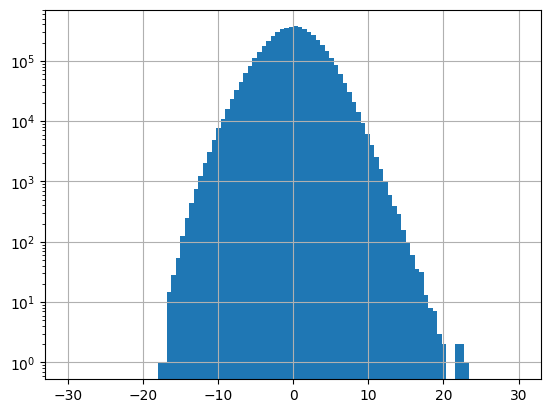

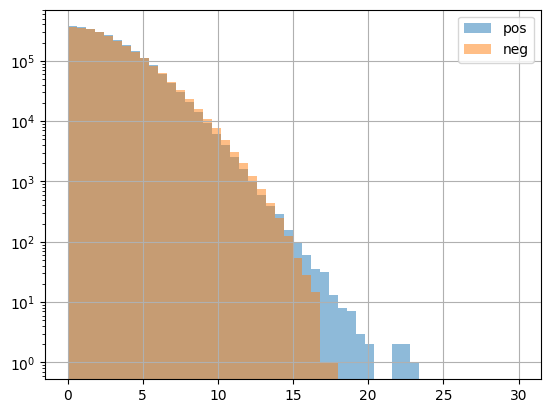

In [261]:
tmp = phi_s.cpu().reshape((-1))
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-30,30));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,30),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,30),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

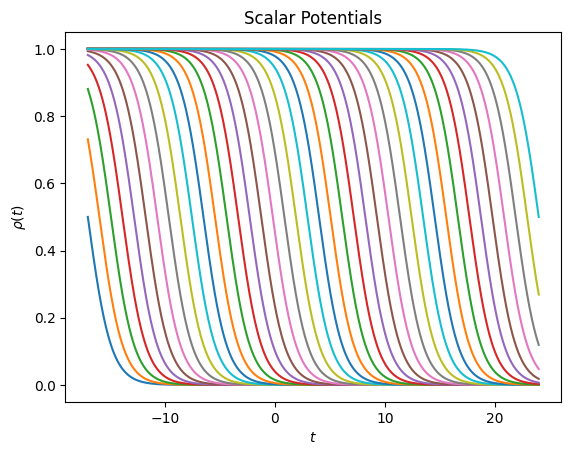

In [262]:
#Scalar Potentials Positioning
num_potentials = 40
window_min,window_max = (-17, 24) #phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =1,device=device)
#centers,sigma = quantile_centers(phi_s,num_potentials,quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)
#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(6,6)   #shifts_quad(8,8) # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [263]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=50) # JEC was phi_s[::50] 19/6/23
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
my_optim(ansatz,dataloader,num_epochs=50,lr=2e-3,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=10,lr=1e-3,momentum=0,weight_decay=0)

[0/50] loss: -53.56443
[1/50] loss: -92.912125
[2/50] loss: -118.21938
[3/50] loss: -133.7984
[4/50] loss: -150.64279
[5/50] loss: -157.778
[6/50] loss: -164.63596
[7/50] loss: -172.47067
[8/50] loss: -176.47856
[9/50] loss: -180.69498
[10/50] loss: -181.7883
[11/50] loss: -182.7574
[12/50] loss: -189.03127
[13/50] loss: -190.03822
[14/50] loss: -192.8868
[15/50] loss: -192.08498
[16/50] loss: -193.8853
[17/50] loss: -195.42354
[18/50] loss: -195.90781
[19/50] loss: -193.51028
[20/50] loss: -200.68309
[21/50] loss: -197.14886
[22/50] loss: -197.67369
[23/50] loss: -196.18344
[24/50] loss: -198.6145
[25/50] loss: -200.90324
[26/50] loss: -196.35773
[27/50] loss: -201.05321
[28/50] loss: -200.02855
[29/50] loss: -201.20392
[30/50] loss: -204.97908
[31/50] loss: -202.04301
[32/50] loss: -203.9713
[33/50] loss: -205.01326
[34/50] loss: -201.87599
[35/50] loss: -207.92543
[36/50] loss: -201.65839
[37/50] loss: -203.75491
[38/50] loss: -202.13326
[39/50] loss: -202.70972
[40/50] loss: -200.9

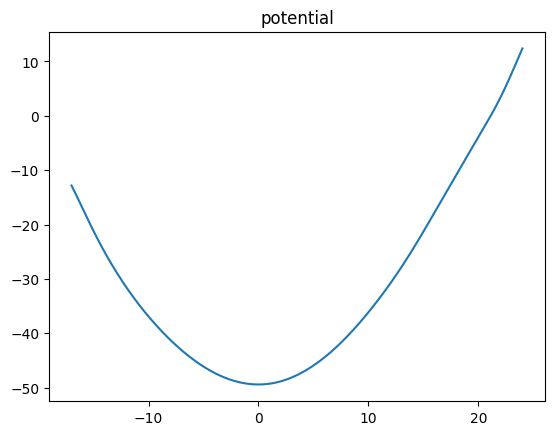

In [264]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [265]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 64

In [24]:
import gc
gc.collect()
torch.cuda.empty_cache()


In [25]:
L=64
depth = J-int(np.log2(L))
print('depth = '+str(depth))
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 1


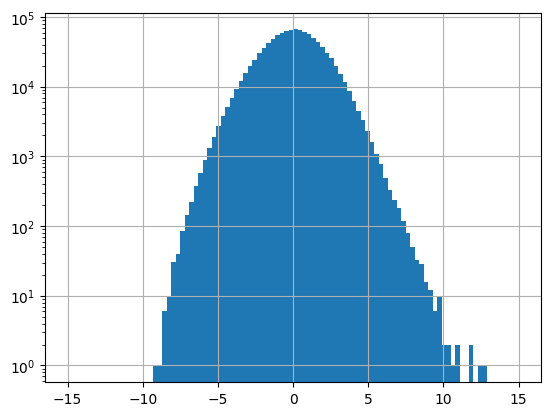

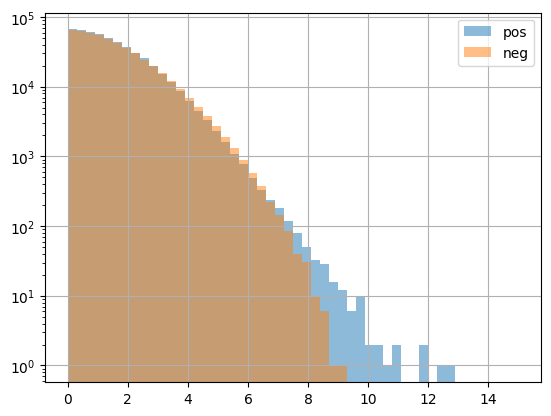

In [26]:
tmp = phi_s.cpu().reshape((-1))[::20]
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-15,15));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,15),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,15),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

In [27]:
phi_s.min(),phi_s.max()

(tensor(-9.7761, device='cuda:0'), tensor(16.5825, device='cuda:0'))

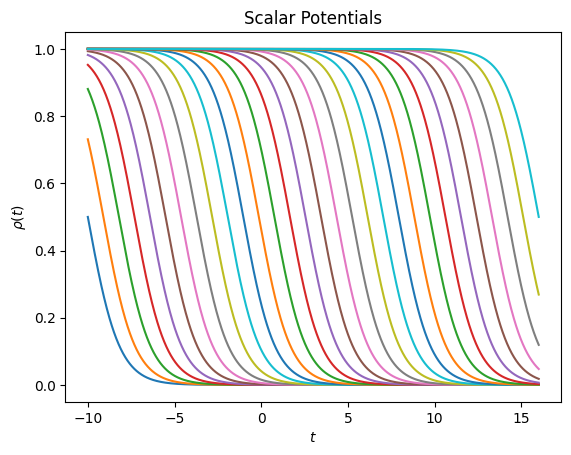

In [28]:
#Scalar Potentials Positioning
num_potentials = 30
window_min,window_max = (-10,16) #phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent=1.0,device=device)
#centers,sigma = quantile_centers(phi_s[::10],num_potentials,quantile_min=0.0,quantile_max=1.0,
#                                 extent =1.0,device=device)

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(6,6)  # shifts_quad(4,4) # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [29]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::20], batch_size=50)  # JEC was phi_s[::20] 19/6/23
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
my_optim(ansatz,dataloader,num_epochs=40,lr=1e-2,momentum=0,weight_decay=0)
my_optim(ansatz,dataloader,num_epochs=20,lr=1e-3,momentum=0,weight_decay=0)


[0/40] loss: -2143.6008
[1/40] loss: -3224.3723
[2/40] loss: -3779.3423
[3/40] loss: -4147.4092
[4/40] loss: -4345.0498
[5/40] loss: -4539.707
[6/40] loss: -4694.4004
[7/40] loss: -4792.8833
[8/40] loss: -4912.7354
[9/40] loss: -5026.8896
[10/40] loss: -5066.8735
[11/40] loss: -5031.8867
[12/40] loss: -5160.5737
[13/40] loss: -5147.0654
[14/40] loss: -5219.1182
[15/40] loss: -5199.0835
[16/40] loss: -5233.7842
[17/40] loss: -5273.0269
[18/40] loss: -5290.645
[19/40] loss: -5320.373
[20/40] loss: -5303.1255
[21/40] loss: -5290.9536
[22/40] loss: -5379.0596
[23/40] loss: -5296.8701
[24/40] loss: -5323.0605
[25/40] loss: -5345.916
[26/40] loss: -5313.4844
[27/40] loss: -5339.5869
[28/40] loss: -5310.4326
[29/40] loss: -5337.1821
[30/40] loss: -5341.7334
[31/40] loss: -5359.3677
[32/40] loss: -5363.0688
[33/40] loss: -5332.9106
[34/40] loss: -5342.8232
[35/40] loss: -5382.1592
[36/40] loss: -5374.0615
[37/40] loss: -5340.0625
[38/40] loss: -5301.6562
[39/40] loss: -5357.1445
[0/20] loss: -

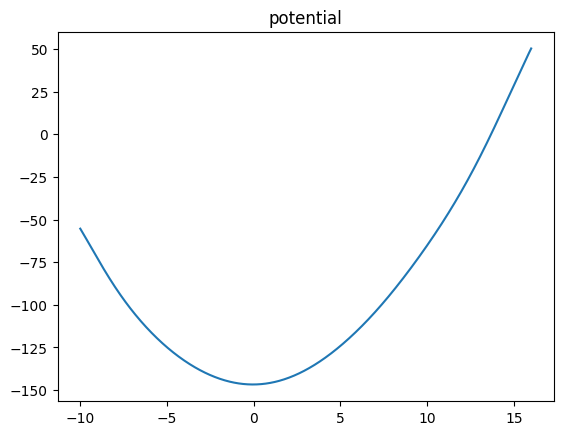

In [30]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [31]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

# L = 128

In [34]:
#Define Scale, maps of size 2^{J-j}*2^{J-j} = L*L
L=128
depth = J-int(np.log2(L))
print('depth = '+str(depth))
#Load Real data x_j, for comparison only
phi_s = load_data(W,Data,depth,J,show_hist=False)

depth = 0


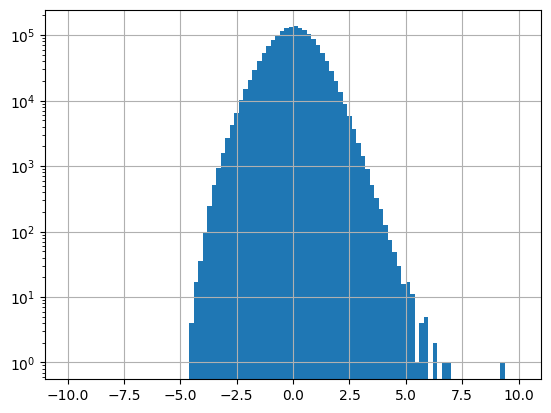

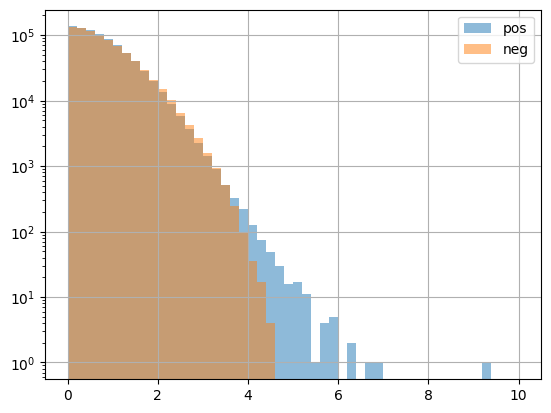

In [35]:
tmp = phi_s.cpu().reshape((-1))[::50]
tmp_pos =  tmp[tmp>=0]
tmp_neg = tmp[tmp<=0]
plt.hist(tmp,bins=100,range=(-10,10));
plt.yscale('log')
plt.grid()
plt.show()
plt.hist(tmp_pos,bins=50,range=(0,10),alpha=0.5,label='pos');
plt.hist(-tmp_neg,bins=50,range=(0,10),alpha=0.5,label='neg');
plt.yscale('log')
plt.legend();
plt.grid()
plt.show()

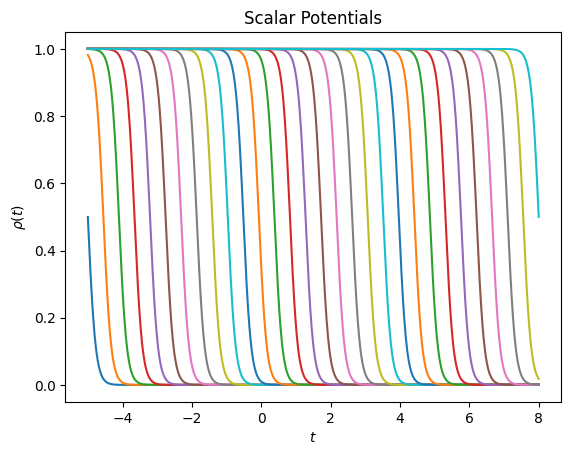

In [36]:
#Scalar Potentials Positioning
num_potentials = 30
window_min,window_max = (-5,8) #phi_s.min(),phi_s.max()
centers,sigma = linspace_centers(window_min,window_max,num_potentials,extent =0.5*0.5,device='cuda')
#centers,sigma = quantile_centers(phi_s[::50],num_potentials, quantile_min=0.0,quantile_max=0.999995,
#                                 extent =1.0,device='cuda')

#Visualize
Plot_Sigmoid(centers,sigma)
#Shifts
shifts = shift_quad_Sym(6,6)  # shifts_quad(6,6) # JEC 14 June 23
mode = 'All'
#Ansatz
ansatz =ANSATZ_Wavelet(W,L,centers,sigma,mode,shifts)

In [37]:
#Train Ansatz
dataloader = torch.utils.data.DataLoader(phi_s[::10], batch_size=10)
#direct_estimate(dataloader,ansatz,mean_mode=False)
Diagonal_Renormalisation(dataloader,ansatz,mean_mode=True)
my_optim(ansatz,dataloader,num_epochs=10,lr=5e-3,momentum=0,weight_decay=0) #epoch 2, lr=2e-2
my_optim(ansatz,dataloader,num_epochs=2,lr=1e-3,momentum=0,weight_decay=0)


[0/10] loss: -133440.58
[1/10] loss: -206063.72
[2/10] loss: -248092.03
[3/10] loss: -275102.88
[4/10] loss: -291736.06
[5/10] loss: -303198.88
[6/10] loss: -310852.0
[7/10] loss: -314815.5
[8/10] loss: -316407.59
[9/10] loss: -319739.75
[0/2] loss: -319448.94
[1/2] loss: -320109.59


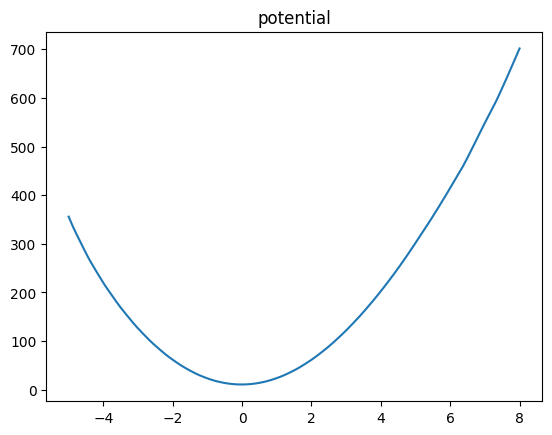

In [38]:
#Visualize Potential
Show_Sigmoid(ansatz)

In [39]:
#save
save_ansatz(ansatz,L,KEY,dir_mod)

In [40]:
Nscale=8 # 8

STD = []
for j in range(1,Nscale):
  L=2**j
  depth = J-int(np.log2(L))
  print('depth = '+str(depth))
  phi_s = load_data(W,Data,depth,J,show_hist=False)
  STD.append(phi_s.std())

depth = 6
depth = 5
depth = 4
depth = 3
depth = 2
depth = 1
depth = 0


In [41]:
ANSATZ =[]
for j in range(1,Nscale):
  L=2**j
  ANSATZ.append(load_ansatz(L,KEY,dir_mod))


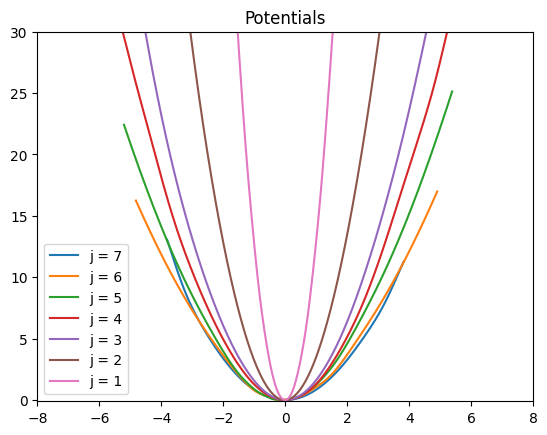

In [42]:
index_scalar=0
index_quad=1
for j in range(1,Nscale):
  Sc = ANSATZ[j-1].ansatze[index_scalar]
  window_min =Sc.centers[0]
  window_max =Sc.centers[-1]
  #POTENTIAL
  X=torch.linspace(window_min,window_max,1000).cuda()
  U=torch.sigmoid(-(X[None, :] - Sc.centers[:, None]) / (Sc.sigma[:,None] )) # (M, D) to (M,)

  #Num_potentials
  n_pot = 0
  for i in range(0,index_scalar):
    n_pot+=ansatz_union.ansatze[i].num_potentials
  n_scalar = ANSATZ[j-1].ansatze[index_scalar].num_potentials
  #theta learned
  theta =ANSATZ[j-1].theta()[n_pot:n_pot+n_scalar]

  #Compute Trace

  Sq = Square_laplacian(ANSATZ[j-1],Free=False,index_quad=index_quad)
  U=(theta@U+(Sq/2)*X**2).cpu().detach()
  U= U-(U[100:]).min()

  plt.plot(X.cpu().detach()/STD[j-1].cpu(),U.cpu(),label='j = '+str(J-j+1))
plt.legend()
plt.xlim(-8,8)
plt.ylim(-0.1,30)
plt.title('Potentials')
plt.show()